In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import warnings
from secret import path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import skfuzzy as fuzz
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTETomek
from scipy.stats import shapiro
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings("ignore")

In [3]:
# Loading our dataset in pandas libraries for analysis and data manipulation if needed
main_df = pd.read_csv(path+"\\creditcard.csv")
main_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
value_counts = main_df['Class'].value_counts()
# Access the counts for 0 and 1
count_0 = value_counts.get(0, 0)  # Get count of 0, default to 0 if not found
count_1 = value_counts.get(1, 0)  # Get count of 1, default to 0 if not found

print(f"Count of 0s: {count_0}")
print(f"Count of 1s: {count_1}")

Count of 0s: 284315
Count of 1s: 492


## **With such severe class imbalance we will have to balance the target class**
To do that we will be using **Combining Oversampling and Undersampling**:<br>
A hybrid approach that involves both oversampling the minority class and undersampling the majority class can sometimes be effective. This combination aims to balance the class distribution while retaining important data from both classes.

**Models we will be using for class balancing**<br>
Combining oversampling and undersampling techniques can help mitigate class imbalance effectively. The idea is to oversample the minority class and undersample the majority class. One common method for doing this is to apply **SMOTE** to oversample the minority class and **Tomek links** to undersample the majority class.

In [5]:
# Split the dataset into features (X) and the target (y)
X = main_df.drop('Class', axis=1)
y = main_df['Class']

In [6]:
# Splitting the data into trainig and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Applying SMOTE and Tomek Link
smt = SMOTETomek(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

In [7]:
value_counts = y_resampled.value_counts()
# Access the counts for 0 and 1
count_0 = value_counts.get(0, 0)  # Get count of 0, default to 0 if not found
count_1 = value_counts.get(1, 0)  # Get count of 1, default to 0 if not found

print(f"Count of 0s: {count_0}")
print(f"Count of 1s: {count_1}")

Count of 0s: 189878
Count of 1s: 189878


In [8]:
new_X = X_resampled.drop(columns=['Time', 'Amount'])
new_y = y_resampled

In [9]:
new_df = pd.concat([new_X, new_y], axis=1)

In [10]:
new_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.146174,-0.083967,0.602963,0.725410,-0.396283,0.186275,-0.318544,0.185287,0.362387,-0.085385,...,-0.155253,-0.012052,0.219314,-0.068172,0.077802,0.482796,0.451360,-0.002776,-0.003524,0
1,-0.918050,0.578744,1.168159,-0.862173,0.969264,0.483973,0.953430,0.188512,-0.866718,-0.734780,...,0.104206,0.102956,0.073220,-0.324398,-1.129387,0.622502,0.395548,-0.042526,0.032731,0
2,-2.013096,-3.261460,-1.443935,0.149307,2.734412,-1.572646,0.380914,-0.058952,0.668700,-1.065447,...,1.377841,0.398680,0.005726,1.652294,0.136111,-1.705085,-0.522617,-0.031407,0.243772,0
3,-0.767334,0.383415,0.210914,0.035407,0.059217,1.220341,-0.053366,0.718190,-1.945750,0.732852,...,-0.064315,-0.145465,-0.121835,-0.023886,-1.764699,-0.060345,-0.080600,0.292808,0.112469,0
4,-0.817828,1.621705,0.911472,1.305673,-0.402086,1.031816,-1.972642,-5.092458,-1.570995,-1.018347,...,1.300047,-2.932584,-0.519522,0.194226,0.138621,0.768231,-0.580148,0.027377,0.213998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379751,0.679700,1.540100,-3.973319,3.246800,-1.318832,-1.247697,-2.690558,0.945387,-0.860826,-3.528455,...,0.222976,0.702632,0.808361,0.249517,-0.083311,-0.624011,-0.125647,0.512995,0.118961,1
379752,-3.066417,3.103746,-6.007741,6.115009,-3.421706,-2.245275,-7.047451,2.241073,-4.059386,-8.106495,...,0.724847,1.402739,0.335055,-0.440825,0.276359,-0.248180,0.091298,1.490299,0.362991,1
379753,-5.332616,4.158638,-8.559197,8.291702,-5.729850,-3.061968,-10.986349,3.413224,-6.158060,-11.481715,...,1.151241,2.322009,0.832277,-0.594645,0.519497,-0.693671,0.331819,2.231584,0.493555,1
379754,-4.263903,5.634666,-6.869213,6.416934,-2.159099,-0.856003,-7.296221,-2.957433,-4.322919,-8.244381,...,1.824317,-0.949120,1.340380,-0.008937,-0.393551,0.212535,0.168180,0.298572,0.169891,1


In [11]:
# Concise summary of data, including information about missing values and data types
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379756 entries, 0 to 379755
Data columns (total 29 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      379756 non-null  float64
 1   V2      379756 non-null  float64
 2   V3      379756 non-null  float64
 3   V4      379756 non-null  float64
 4   V5      379756 non-null  float64
 5   V6      379756 non-null  float64
 6   V7      379756 non-null  float64
 7   V8      379756 non-null  float64
 8   V9      379756 non-null  float64
 9   V10     379756 non-null  float64
 10  V11     379756 non-null  float64
 11  V12     379756 non-null  float64
 12  V13     379756 non-null  float64
 13  V14     379756 non-null  float64
 14  V15     379756 non-null  float64
 15  V16     379756 non-null  float64
 16  V17     379756 non-null  float64
 17  V18     379756 non-null  float64
 18  V19     379756 non-null  float64
 19  V20     379756 non-null  float64
 20  V21     379756 non-null  float64
 21  V22     37

In [12]:
# Basic statistics for each numeric column, such as mean, min, max, etc
new_df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,...,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000,379756.000000
mean,-2.200265,1.757693,-3.439202,2.318355,-1.455467,-0.743176,-2.651231,0.467233,-1.287373,-2.780981,...,0.165783,0.318771,0.014259,-0.049150,-0.056204,0.026099,0.048025,0.098248,0.039955,0.500000
std,5.013107,3.320793,5.790576,3.108122,3.845931,1.611285,5.181273,3.811937,2.159098,4.210190,...,0.927889,1.973545,0.924262,0.964289,0.538511,0.619208,0.449111,0.900156,0.403250,0.500001
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,-24.588262,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,0.000000
25%,-2.827974,-0.095068,-5.207258,-0.062661,-1.747905,-1.529695,-3.152308,-0.184902,-2.292297,-4.542348,...,-0.190609,-0.151305,-0.500178,-0.229720,-0.388084,-0.299653,-0.256343,-0.063915,-0.058258,0.000000
50%,-0.765140,1.011116,-1.524533,1.494238,-0.415271,-0.701114,-0.754119,0.172513,-0.793219,-1.031135,...,0.035765,0.168190,0.018283,-0.033461,-0.005785,0.050646,0.022322,0.060911,0.035848,0.500000
75%,0.851278,2.876505,0.274741,4.489177,0.443977,-0.010115,0.183228,0.848806,0.091680,-0.033860,...,0.421627,0.639640,0.511562,0.176604,0.336114,0.372856,0.328695,0.438077,0.201878,1.000000
max,2.454930,22.057729,4.187811,16.875344,34.801666,73.301626,120.589494,20.007208,10.348407,15.245686,...,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.000000


In [13]:
# Calculating the percentage of null/Nan values in our dataset.
(new_df[new_df.columns].isnull().sum()/new_df.shape[0])*100

V1       0.0
V2       0.0
V3       0.0
V4       0.0
V5       0.0
V6       0.0
V7       0.0
V8       0.0
V9       0.0
V10      0.0
V11      0.0
V12      0.0
V13      0.0
V14      0.0
V15      0.0
V16      0.0
V17      0.0
V18      0.0
V19      0.0
V20      0.0
V21      0.0
V22      0.0
V23      0.0
V24      0.0
V25      0.0
V26      0.0
V27      0.0
V28      0.0
Class    0.0
dtype: float64

# **Shapiro-Wilk Test**
- The Shapiro-Wilk test is a statistical test that checks if a dataset follows a normal distribution. A low p-value (typically less than 0.05) indicates that the data significantly deviates from a normal distribution.

In [14]:
# Performing the Shapiro-Wilk test for each column in main_df
for column in new_df.columns:
    stat, p = shapiro(new_df[column])
    print(f'{column}: Statistics={stat}, p={p}')

V1: Statistics=0.7069604396820068, p=0.0
V2: Statistics=0.8459051251411438, p=0.0
V3: Statistics=0.7683205604553223, p=0.0
V4: Statistics=0.9536792039871216, p=0.0
V5: Statistics=0.7399948239326477, p=0.0
V6: Statistics=0.9486317038536072, p=0.0
V7: Statistics=0.6992595195770264, p=0.0
V8: Statistics=0.5835127234458923, p=0.0
V9: Statistics=0.9311937689781189, p=0.0
V10: Statistics=0.833716630935669, p=0.0
V11: Statistics=0.9252386689186096, p=0.0
V12: Statistics=0.8450649976730347, p=0.0
V13: Statistics=0.9987892508506775, p=1.4566838780858506e-36
V14: Statistics=0.8777220249176025, p=0.0
V15: Statistics=0.9890421628952026, p=0.0
V16: Statistics=0.8347029685974121, p=0.0
V17: Statistics=0.7863301634788513, p=0.0
V18: Statistics=0.8606085181236267, p=0.0
V19: Statistics=0.9806700348854065, p=0.0
V20: Statistics=0.7257179021835327, p=0.0
V21: Statistics=0.5168805718421936, p=0.0
V22: Statistics=0.8532589077949524, p=0.0
V23: Statistics=0.507538914680481, p=0.0
V24: Statistics=0.98505878

# **Histograms**
- Visualize the distribution of each feature using histograms. Normally distributed data should resemble a bell curve.

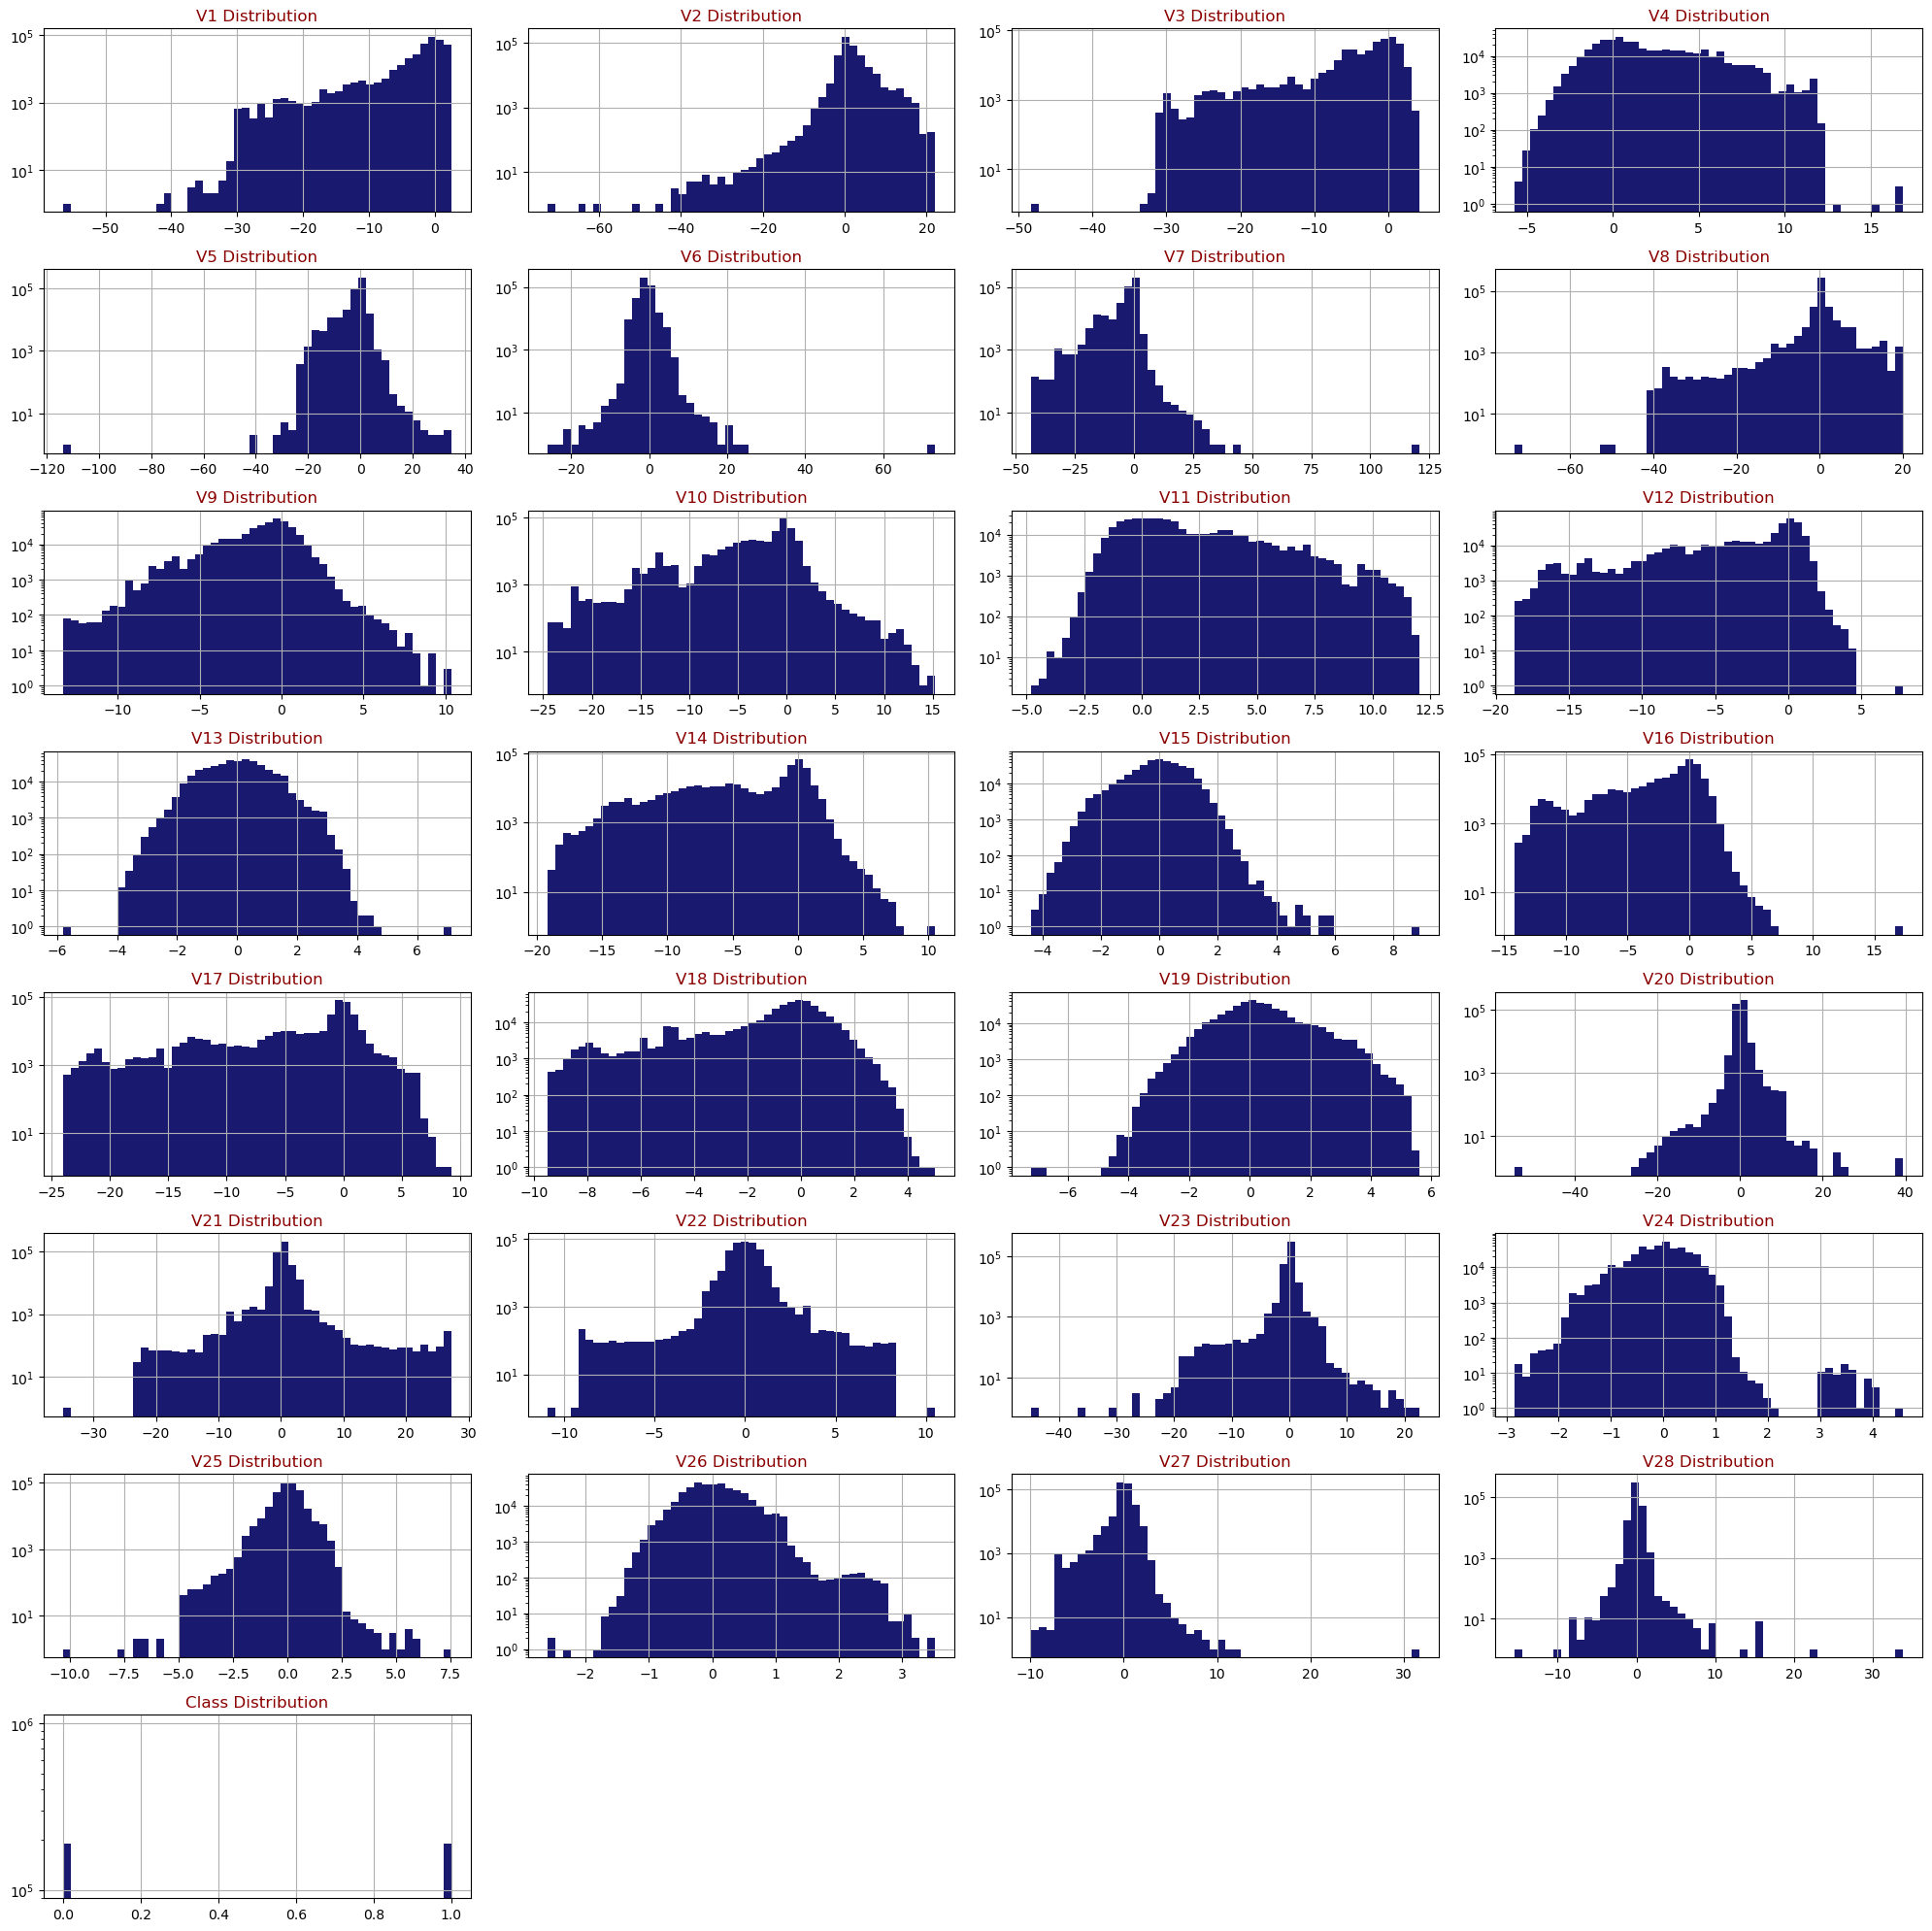

In [15]:
def draw_histograms(df, features, rows, columns):
    fig = plt.figure(figsize=(20, 20))
    for i, features in enumerate(features):
        ax = fig.add_subplot(rows, columns, i+1)
        df[features].hist(bins = 50 , ax = ax, facecolor='midnightblue')
        ax.set_title(features+" Distribution", color="DarkRed")
        ax.set_yscale('log')
    fig.tight_layout()
    plt.show()  
    
draw_histograms(new_df, new_df.columns, 8, 4)

# **Q-Q Plots**
- Quantile-quantile (Q-Q) plots compare the quantiles of your data to the quantiles of a theoretical normal distribution. Normally distributed data should roughly follow a diagonal line.

In [16]:
def draw_qq_plots(df, features, rows, columns):
    fig = plt.figure(figsize=(20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, columns, i+1)
        sm.qqplot(df[feature], line='s', ax=ax)
        ax.set_title(f'Q-Q Plot for {feature}', color='DarkRed')
    fig.tight_layout()
    plt.show()

draw_qq_plots(new_df, new_df.columns, 8, 4)


# **Data Normalization for Machine Learning**
From our above statistical analysis we can see our data is not normalized so we are going to normalize our data.

In [17]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on your dataset
normalized_data = scaler.fit_transform(new_df)

# Convert the normalized data back to a DataFrame
normalized_df = pd.DataFrame(data=normalized_data, columns=new_df.columns)

# Check the first few rows of the normalized DataFrame
normalized_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.667539,-0.554585,0.698060,-0.512511,0.275404,0.576839,0.450216,-0.073964,0.764098,0.640256,...,-0.345986,-0.167629,0.221859,-0.019727,0.248846,0.737551,0.898075,-0.112229,-0.107821,-1.0
1,0.255773,-0.355021,0.795666,-1.023297,0.630467,0.761597,0.695710,-0.073118,0.194829,0.486012,...,-0.066363,-0.109354,0.063792,-0.285442,-1.992875,0.963172,0.773802,-0.156388,-0.017913,-1.0
2,0.037336,-1.511434,0.344572,-0.697865,1.089433,-0.514788,0.585213,-0.138036,0.905969,0.407472,...,1.306254,0.040490,-0.009232,1.764456,0.357125,-2.795806,-1.270604,-0.144036,0.505437,-1.0
3,0.285837,-0.413841,0.630355,-0.734511,0.393841,1.218605,0.501396,0.065835,-0.304932,0.834603,...,-0.247981,-0.235230,-0.147246,0.026199,-3.172636,-0.139605,-0.286400,0.216141,0.179826,-1.0
4,0.275765,-0.040950,0.751338,-0.325818,0.273895,1.101601,0.130970,-1.458497,-0.131362,0.418659,...,1.222415,-1.647471,-0.577522,0.252389,0.361785,1.198520,-1.398704,-0.078732,0.431601,-1.0


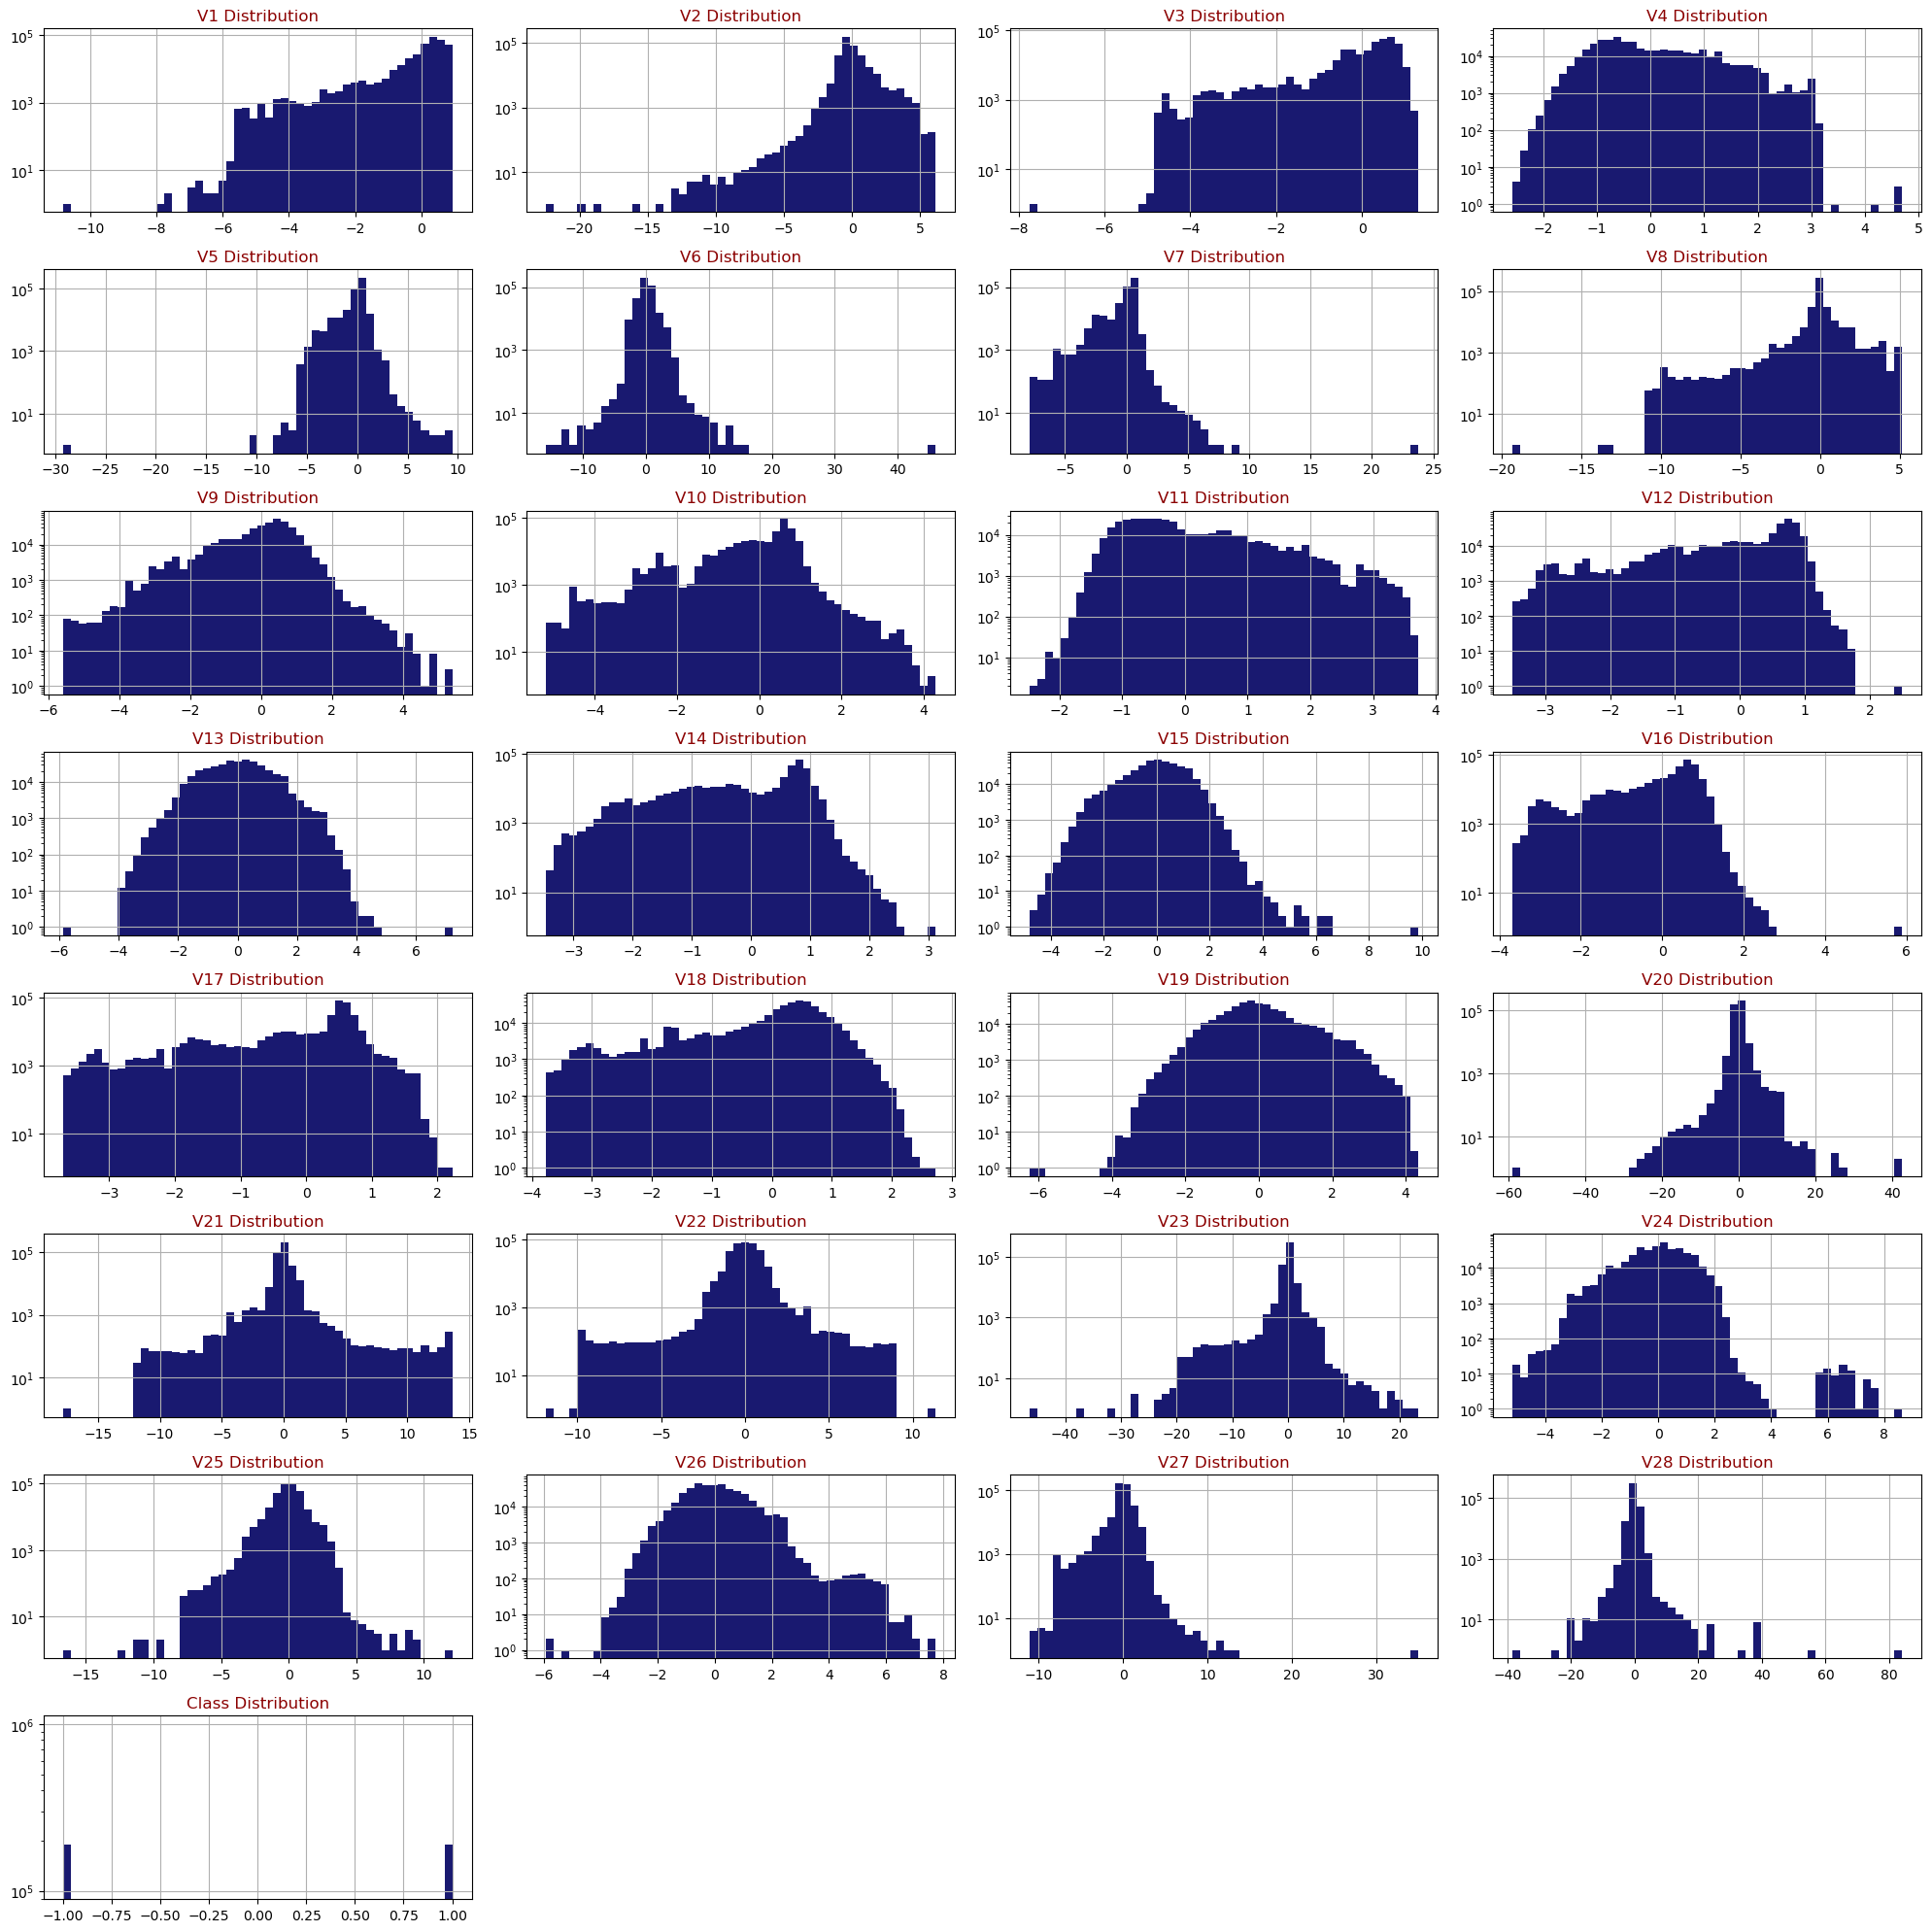

In [18]:
def draw_histograms(df, features, rows, columns):
    fig = plt.figure(figsize=(20, 20))
    for i, features in enumerate(features):
        ax = fig.add_subplot(rows, columns, i+1)
        df[features].hist(bins = 50 , ax = ax, facecolor='midnightblue')
        ax.set_title(features+" Distribution", color="DarkRed")
        ax.set_yscale('log')
    fig.tight_layout()
    plt.show()  
    
draw_histograms(normalized_df, normalized_df.columns, 8, 4)

In [19]:
# Performing the Shapiro-Wilk test for each column in main_df
for column in normalized_df.columns:
    stat, p = shapiro(normalized_df[column])
    print(f'{column}: Statistics={stat}, p={p}')

V1: Statistics=0.7069606781005859, p=0.0
V2: Statistics=0.8459049463272095, p=0.0
V3: Statistics=0.7683206796646118, p=0.0
V4: Statistics=0.9536790251731873, p=0.0
V5: Statistics=0.739995002746582, p=0.0
V6: Statistics=0.9486318826675415, p=0.0
V7: Statistics=0.6992595195770264, p=0.0
V8: Statistics=0.583512544631958, p=0.0
V9: Statistics=0.9311938881874084, p=0.0
V10: Statistics=0.8337163925170898, p=0.0
V11: Statistics=0.9252384901046753, p=0.0
V12: Statistics=0.8450646996498108, p=0.0
V13: Statistics=0.9987892508506775, p=1.4566838780858506e-36
V14: Statistics=0.8777218461036682, p=0.0
V15: Statistics=0.9890421628952026, p=0.0
V16: Statistics=0.8347032070159912, p=0.0
V17: Statistics=0.7863300442695618, p=0.0
V18: Statistics=0.8606083989143372, p=0.0
V19: Statistics=0.9806703925132751, p=0.0
V20: Statistics=0.7257179617881775, p=0.0
V21: Statistics=0.5168806314468384, p=0.0
V22: Statistics=0.8532589673995972, p=0.0
V23: Statistics=0.507538914680481, p=0.0
V24: Statistics=0.985058963

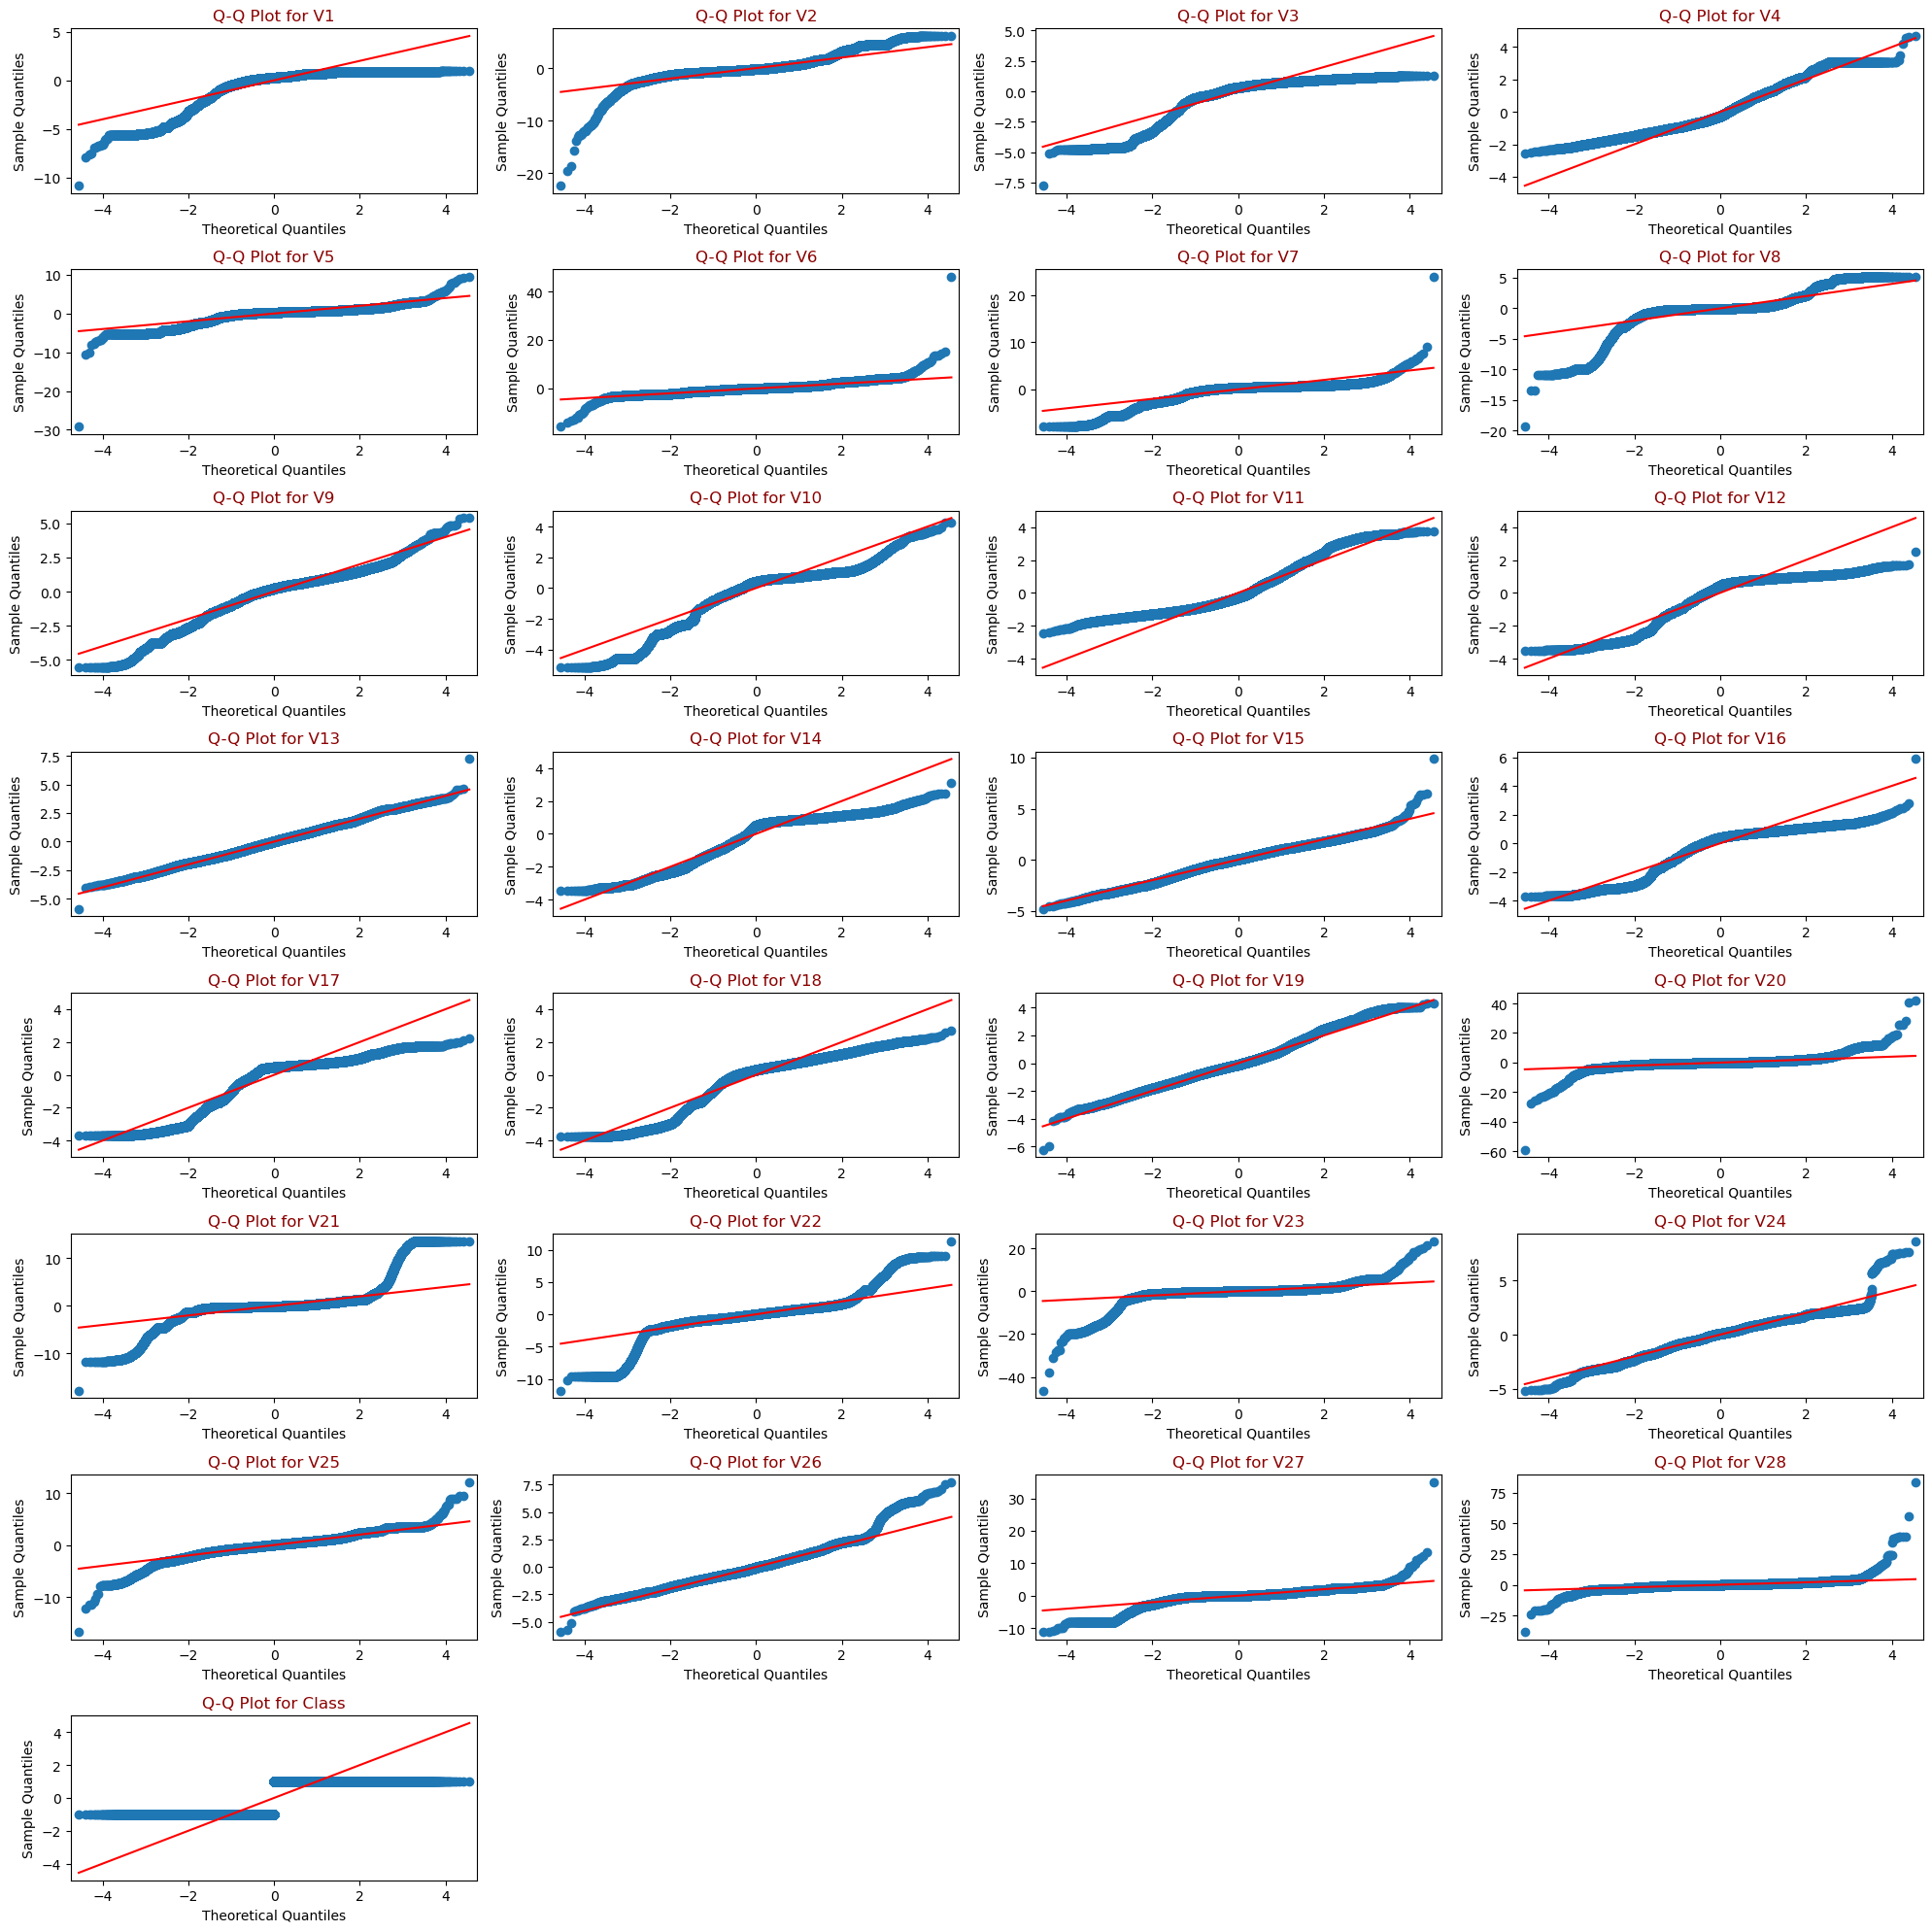

In [20]:
def draw_qq_plots(df, features, rows, columns):
    fig = plt.figure(figsize=(20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, columns, i+1)
        sm.qqplot(df[feature], line='s', ax=ax)
        ax.set_title(f'Q-Q Plot for {feature}', color='DarkRed')
    fig.tight_layout()
    plt.show()

draw_qq_plots(normalized_df, normalized_df.columns, 8, 4)

In [21]:
# Assignment of training set...
X_train, y_train = X_resampled, y_resampled

# Defining the number of features to select (N)
N = 10

In [22]:
# Method 1: Mutual Information for feature selection
mi_selector = SelectKBest(mutual_info_classif, k=N)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
X_test_mi = mi_selector.transform(X_test)

In [23]:
# Method 2: SelectKBest (e.g., chi-squared) for feature selection
skb_selector = SelectKBest(k=N)
X_train_skb = skb_selector.fit_transform(X_train, y_train)
X_test_skb = skb_selector.transform(X_test)

In [24]:
# Method 3: Random Forest Classifier (RFC) for feature selection
# Fit a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Sort feature indices by importance
selected_feature_indices = np.argsort(feature_importances)[::-1]
selected_feature_indices = selected_feature_indices[selected_feature_indices < X_train.shape[1]]

# Select the top N features
top_N_features = X_train.columns[selected_feature_indices[:N]]


In [25]:
# Selecting the feature from datasets
# Extract the selected features from your dataset
X_train_rfc = X_train[top_N_features]
X_test_rfc = X_test[top_N_features]

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for n_neighbors
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Initialize KNeighborsClassifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_n_neighbors = best_params['n_neighbors']

# Print the best parameters
print(f"Best Number of Neighbors: {best_n_neighbors}")

# Use the best n_neighbors for your KNeighborsClassifier
knn_best = KNeighborsClassifier(n_neighbors=best_n_neighbors)

In [26]:
# Train and evaluate a K-Nearest Neighbors (KNN) classifier using full dataset...
knn = KNeighborsClassifier(n_neighbors=5)

# Evaluating Full dataset
print("Fitting KNN with Full Dataset...")
knn.fit(X_train, y_train)
print("Predicting with Full Dataset...")
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
clr = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:\n", clr)
print("\n\n")

Fitting KNN with Full Dataset...
Predicting with Full Dataset...
Accuracy: 0.945215827720855
Precision: 0.015503875968992248
Recall: 0.5369127516778524
F1 Score: 0.03013750235449237
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     93838
           1       0.02      0.54      0.03       149

    accuracy                           0.95     93987
   macro avg       0.51      0.74      0.50     93987
weighted avg       1.00      0.95      0.97     93987






In [27]:
# Train and evaluate a K-Nearest Neighbors (KNN) classifier using each selected feature set
knn = KNeighborsClassifier(n_neighbors=5)

# Evaluating Mutual Information selected features
print("Fitting KNN with Mutual Information selected features...")
knn.fit(X_train_mi, y_train)
print("Predicting with Mutual Information selected features...")
y_pred_mi = knn.predict(X_test_mi)
accuracy_mi = accuracy_score(y_test, y_pred_mi)
precision_mi = precision_score(y_test, y_pred_mi)
recall_mi = recall_score(y_test, y_pred_mi)
f1_mi = f1_score(y_test, y_pred_mi)
clr_mi = classification_report(y_test, y_pred_mi)
print("Accuracy:", accuracy_mi)
print("Precision:", precision_mi)
print("Recall:", recall_mi)
print("F1 Score:", f1_mi)
print("Classification Report:\n", clr_mi)
print("\n\n")

Fitting KNN with Mutual Information selected features...
Predicting with Mutual Information selected features...
Accuracy: 0.9896794237500931
Precision: 0.12304866850321396
Recall: 0.8993288590604027
F1 Score: 0.21647819063004847
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     93838
           1       0.12      0.90      0.22       149

    accuracy                           0.99     93987
   macro avg       0.56      0.94      0.61     93987
weighted avg       1.00      0.99      0.99     93987






In [28]:
X_test_skb

array([[  8.5849718 , -18.64985319,   9.50559352, ...,  -9.37385858,
         -9.89924654, -19.23629237],
       [ -2.74374524,  -0.13406951,  -1.38572931, ...,  -0.21788381,
         -2.14289209,   0.12695606],
       [ -0.59070129,   0.16861894,  -1.02995033, ...,  -0.24577198,
          1.76986004,  -0.53317225],
       ...,
       [ -0.9024431 ,   0.11125961,  -1.52168905, ...,  -0.63551482,
         -0.22214346,   0.12439602],
       [ -0.8795148 ,   0.11113344,  -0.79806133, ...,   0.02044733,
          1.2077658 ,   0.28292711],
       [ -0.08027462,  -1.2337215 ,   0.18419124, ...,   0.35208545,
          0.20851489,  -0.73810979]])

In [29]:
# Evaluating SelectKBest selected features
print("Fitting with SelectKBest selected features...")
knn.fit(X_train_skb, y_train)
print("Predicting with SelectKBest selected features...")
y_pred_skb = knn.predict(X_test_skb)
accuracy_skb = accuracy_score(y_test, y_pred_skb)
precision_skb = precision_score(y_test, y_pred_skb)
recall_skb = recall_score(y_test, y_pred_skb)
f1_skb = f1_score(y_test, y_pred_skb)
clr_skb = classification_report(y_test, y_pred_skb)
print("Accuracy:", accuracy_skb)
print("Precision:", precision_skb)
print("Recall:", recall_skb)
print("F1 Score:", f1_skb)
print("Classification Report:\n", clr_skb)
print("\n\n")


Fitting with SelectKBest selected features...
Predicting with SelectKBest selected features...
Accuracy: 0.9978826859033696
Precision: 0.42138364779874216
Recall: 0.8993288590604027
F1 Score: 0.5738758029978587
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     93838
           1       0.42      0.90      0.57       149

    accuracy                           1.00     93987
   macro avg       0.71      0.95      0.79     93987
weighted avg       1.00      1.00      1.00     93987






In [1]:
# Evaluating RFC selected features
print("Fitting with Random Forest Classifier selected features...")
knn.fit(X_train_rfc, y_train)
print("Predicting with Random Forest Classifier selected features...")
y_pred_rfc = knn.predict(X_test_rfc)
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
precision_rfc = precision_score(y_test, y_pred_rfc)
recall_rfc = recall_score(y_test, y_pred_rfc)
f1_rfc = f1_score(y_test, y_pred_rfc)
clr_rfc = classification_report(y_test, y_pred_rfc)
print("Accuracy:", accuracy_rfc)
print("Precision:", precision_rfc)
print("Recall:", recall_rfc)
print("F1 Score:", f1_rfc)
print("Classification Report:\n", clr_rfc)

Fitting with Random Forest Classifier selected features...


NameError: name 'knn' is not defined

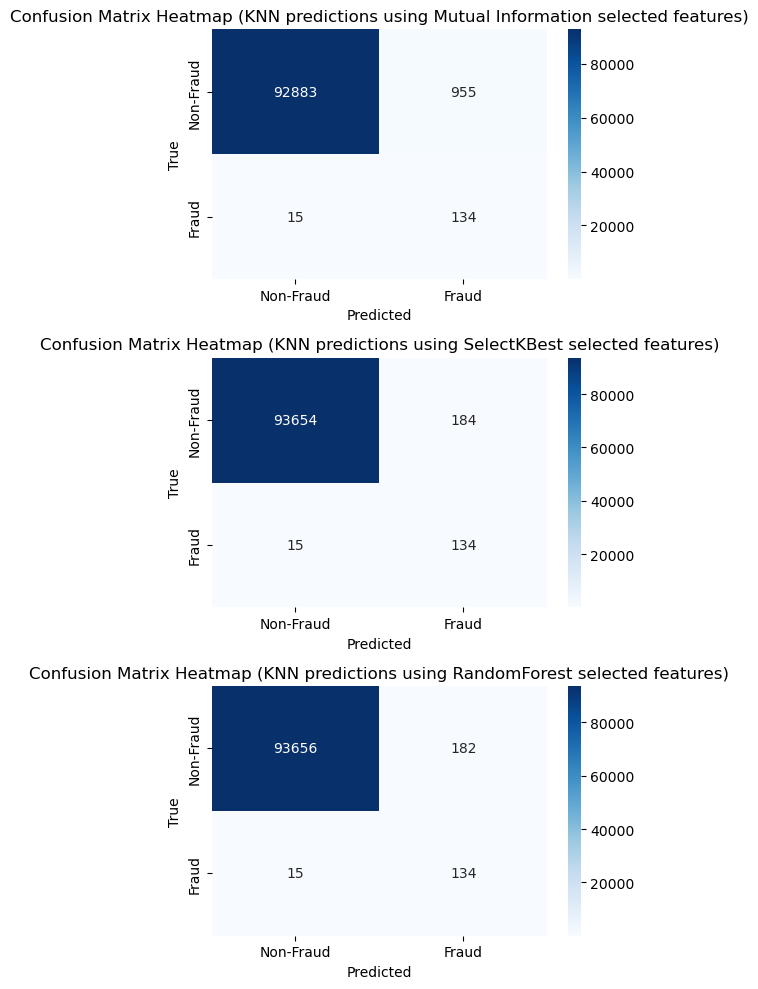

In [31]:
# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(3, 1, figsize=(5, 10))

# Computing confusion matrices for KNN and Random Forest
cm_mi = confusion_matrix(y_test, y_pred_mi)
cm_skb = confusion_matrix(y_test, y_pred_skb)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)

# Ploting the confusion matrix for KNN predictions using Mutual Information selected features on the first subplot
sns.heatmap(cm_mi, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix Heatmap (KNN predictions using Mutual Information selected features)')

# Ploting the confusion matrix for KNN predictions using SelectKBest selected features on the second subplot
sns.heatmap(cm_skb, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix Heatmap (KNN predictions using SelectKBest selected features)')

# Ploting the confusion matrix for KNN predictions using RandomForest selected features on the second subplot
sns.heatmap(cm_rfc, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'], ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_title('Confusion Matrix Heatmap (KNN predictions using RandomForest selected features)')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

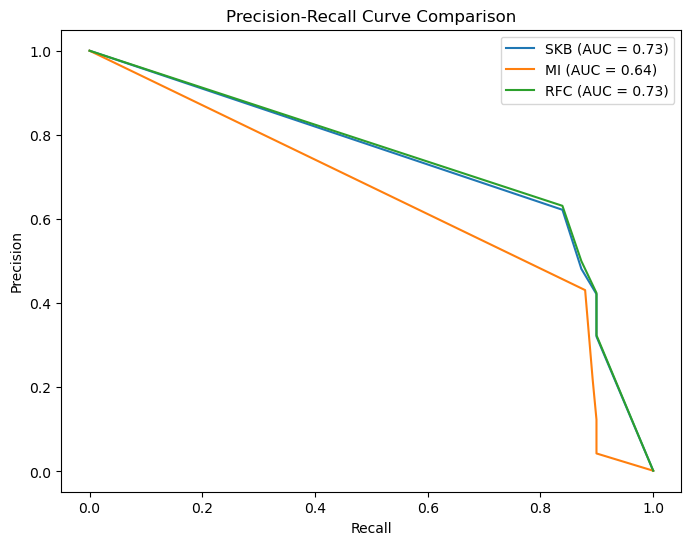

In [32]:
# Create KNN models with selected features
knn_skb = KNeighborsClassifier(n_neighbors=5).fit(X_train_skb, y_train)
knn_mi = KNeighborsClassifier(n_neighbors=5).fit(X_train_mi, y_train)
knn_rfc = KNeighborsClassifier(n_neighbors=5).fit(X_train_rfc, y_train)

# Compute precision-recall curves
y_scores_skb = knn_skb.predict_proba(skb_selector.transform(X_test))[:, 1]
precision_skb, recall_skb, _ = precision_recall_curve(y_test, y_scores_skb)

y_scores_mi = knn_mi.predict_proba(mi_selector.transform(X_test))[:, 1]
precision_mi, recall_mi, _ = precision_recall_curve(y_test, y_scores_mi)

y_scores_rfc = knn_rfc.predict_proba(X_test_rfc)[:, 1]
precision_rfc, recall_rfc, _ = precision_recall_curve(y_test, y_scores_rfc)

# Compute area under the curve (AUC)
auc_score_skb = auc(recall_skb, precision_skb)
auc_score_mi = auc(recall_mi, precision_mi)
auc_score_rfc = auc(recall_rfc, precision_rfc)

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall_skb, precision_skb, label=f'SKB (AUC = {auc_score_skb:.2f})')
plt.plot(recall_mi, precision_mi, label=f'MI (AUC = {auc_score_mi:.2f})')
plt.plot(recall_rfc, precision_rfc, label=f'RFC (AUC = {auc_score_rfc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')
plt.show()

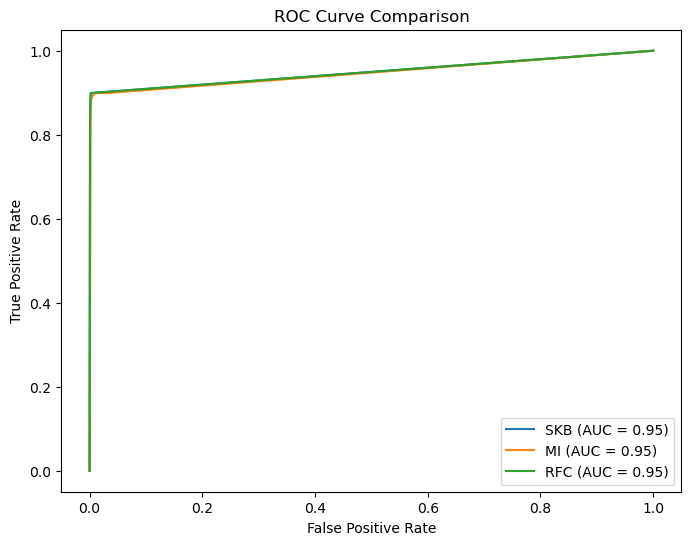

In [33]:
# Computing ROC curves
y_scores_skb = knn_skb.predict_proba(skb_selector.transform(X_test))[:, 1]
fpr_skb, tpr_skb, _ = roc_curve(y_test, y_scores_skb)

y_scores_mi = knn_mi.predict_proba(mi_selector.transform(X_test))[:, 1]
fpr_mi, tpr_mi, _ = roc_curve(y_test, y_scores_mi)

y_scores_rfc = knn_rfc.predict_proba(X_test_rfc)[:, 1]
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_scores_rfc)

# Compute AUC (Area Under the Curve)
auc_score_skb = roc_auc_score(y_test, y_scores_skb)
auc_score_mi = roc_auc_score(y_test, y_scores_mi)
auc_score_rfc = roc_auc_score(y_test, y_scores_rfc)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_skb, tpr_skb, label=f'SKB (AUC = {auc_score_skb:.2f})')
plt.plot(fpr_mi, tpr_mi, label=f'MI (AUC = {auc_score_mi:.2f})')
plt.plot(fpr_rfc, tpr_rfc, label=f'RFC (AUC = {auc_score_rfc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.show()

In [34]:
value_counts = y_test.value_counts()
# Access the counts for 0 and 1
count_0 = value_counts.get(0, 0)  # Get count of 0, default to 0 if not found
count_1 = value_counts.get(1, 0)  # Get count of 1, default to 0 if not found

print(f"Count of 0s: {count_0}")
print(f"Count of 1s: {count_1}")

Count of 0s: 93838
Count of 1s: 149


In [40]:
from skfuzzy.cluster import cmeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize your training data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_rfc)

best_score = -1  # Initialize a variable to track the best score

# Define a range of values to search for n_clusters and m
n_clusters_values = [3, 4, 5, 6]
m_values = [1.1, 1.2, 1.3, 1.4, 1.5]

# Maximum number of iterations
max_iterations = 100

# Tolerance for stopping criteria
tolerance = 1e-6

# Loop over n_clusters and m values to find the best parameters
for n_clusters in n_clusters_values:
    for m in m_values:
        # Train the FCM model with the current parameters
        cntr, u, u0, d, jm, p, fpc = cmeans(X_train_normalized.T, c=n_clusters, m=m, error=tolerance, maxiter=max_iterations)

        # Calculate a score for the quality of the clustering, e.g., using a metric like Davies-Bouldin Index
        # You can replace this with an appropriate clustering evaluation metric
        # Davies-Bouldin Index is used here as an example
        from sklearn.metrics import davies_bouldin_score
        labels = np.argmax(u, axis=0)
        score = davies_bouldin_score(X_train_normalized, labels)

        # Check if the current parameters give a better score
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters
            best_m = m

print("Best Parameters - n_clusters: {}, m: {}".format(best_n_clusters, best_m))


Best Parameters - n_clusters: 6, m: 1.5


In [41]:
from sklearn.metrics import davies_bouldin_score
cntr, u, u0, d, jm, p, fpc = cmeans(X_train_normalized.T, c=6, m=1.5, error=tolerance, maxiter=max_iterations)
labels = np.argmax(u, axis=0)
score = davies_bouldin_score(X_train_normalized, labels)
X_test_normalized = scaler.transform(X_test_rfc)

print("Score:", score)

Score: 1.5202128970947693


In [37]:
X_test_rfc

,V14,V12,V4,V10,V3,V17,V16,V11,V2,V7
43428,-9.373859,-10.834006,9.505594,-14.110184,-18.649853,-19.236292,-9.899247,5.299236,8.584972,-16.701694
49906,-0.217884,0.979427,-1.385729,-0.565012,-0.134070,0.126956,-2.142892,-0.087670,-2.743745,-0.524379
29474,-0.245772,0.112453,-1.029950,0.756801,0.168619,-0.533172,1.769860,0.543827,-0.590701,-0.712567
276481,-0.550875,0.223621,-0.349504,-1.376648,-1.669361,0.502195,0.497974,-1.328335,1.647895,0.276990
278846,0.592634,0.850038,0.327269,0.259452,-1.015839,-0.471867,0.091077,0.942162,-0.137394,0.043241
...,...,...,...,...,...,...,...,...,...,...
211399,-0.889834,1.578678,0.055530,-0.608548,-2.083358,0.883675,-0.449591,1.502239,0.067770,-0.018685
245040,0.448182,-0.724816,-0.577140,-0.369385,0.259483,-0.257243,-0.074275,-1.159282,0.740779,0.880215
97433,-0.635515,-0.403895,-1.521689,1.395496,0.111260,0.124396,-0.222143,-0.985793,-0.902443,-0.816003
94007,0.020447,-1.134753,-0.798061,0.544840,0.111133,0.282927,1.207766,-0.748361,-0.879515,-0.563416
